<a href="https://colab.research.google.com/github/joaoBernardinoo/avoid-obstacle-collision/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import joblib
import matplotlib

In [12]:
# @title Drive
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

In [80]:
# @title Plot

def evaluate_and_plot_prediction(y_test, y_pred,n):
    """
    Calculates errors and generates plots to evaluate prediction performance.

    Args:
        y_test (np.ndarray): Array of real values.
        y_pred (np.ndarray): Array of predicted values.
    """
    errors = y_test - y_pred

    # Calculate metrics
    mae = np.mean(np.abs(errors))
    accuracy = np.mean(np.abs(errors) < 0.2)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Gráfico 1: Predição vs Valor Real
    plt.subplot(131)
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([-2, 2], [-2, 2], 'r--', label='Predição Perfeita')
    plt.plot([-2, 2], [2, -2], 'r--')

    plt.title(f'Predição vs Valor Real\ninput size: {n}')
    plt.xlabel('Valor Real')
    plt.ylabel('Predito')
    plt.grid(True)
    plt.legend()

    # Gráfico 2: Distribuição dos Erros
    plt.subplot(132)
    plt.hist(errors, bins=30, alpha=0.7)
    plt.axvline(0, color='r', linestyle='--')
    plt.title(f'Distribuição dos Erros\nMAE: {mae:.4f}')
    plt.xlabel('Erro (Real - Predito)')
    plt.ylabel('Frequência')
    plt.grid(True)

    # Gráfico 3: Valores Reais vs Preditos
    plt.subplot(133)
    sorted_idx = np.argsort(y_test)
    plt.plot(y_test[sorted_idx], label='Valor Real')
    plt.plot(y_pred[sorted_idx], 'r--', alpha=0.7, label='Predição')
    plt.title(f'Comparação Direta\nAcurácia (erro < 0.1): {accuracy:.2%}')
    plt.xlabel('Amostras Ordenadas')
    plt.ylabel('Valor')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Avaliação de desempenho
    print(f"\nErro Médio Absoluto (MAE): {mae:.4f}")
    print(f"Acurácia (erro < 0.1): {accuracy:.2%}")

In [14]:
import numpy as np

from sklearn.model_selection import train_test_split

# Parameters
n = 20 # Number of input variables (min(a₁, a₂, ..., aₙ))
num_samples = 10000  # Training data size
input_range = (-3.14, 3.14)  # Input values range

import numpy as np

# Funções auxiliares (assumindo que já estão definidas no seu ambiente)
# Exemplo de implementação para que o código seja executável e compreensível:
def closest_to_zero(arr):
    """
    Retorna o valor no array mais próximo de zero.
    Em caso de empate (dois valores com o mesmo valor absoluto, mas sinais diferentes),
    prioriza o valor positivo.
    """
    if arr.size == 0:
        return None
    
    # 1. Calcula o valor absoluto de todos os elementos
    abs_arr = np.abs(arr)
    
    # 2. Encontra o menor valor absoluto presente no array
    min_abs_val = np.min(abs_arr)
    
    # 3. Identifica todos os valores originais que possuem esse menor valor absoluto
    # Isso lida com casos como [-1, 1], [-0.5, 0.5], ou até mesmo apenas [-1] ou apenas [1]
    candidates = arr[abs_arr == min_abs_val]
    
    # 4. Verifica a regra de desempate:
    # Se o valor mais próximo de zero for 0, então 0 é a resposta.
    if min_abs_val == 0:
        return 0
    
    # Verifica se há algum valor positivo entre os candidatos
    # Por exemplo, se candidates é [-1, 1], positive_candidates será [1]
    positive_candidates = candidates[candidates > 0]
    
    if positive_candidates.size > 0:
        # Se houver pelo menos um candidato positivo (e ele já é o 'min_abs_val'),
        # retorna esse valor. Como todos os 'positive_candidates' teriam o mesmo
        # valor absoluto mínimo e seriam positivos, 'np.min' nele retornará o próprio valor.
        return np.min(positive_candidates) # Isso resultará no valor positivo (ex: 1)
    else:
        # Se não houver candidatos positivos (ou seja, todos os candidatos são negativos,
        # como em [-2, -1, -3] onde o candidato é apenas [-1]),
        # retorna o valor negativo. np.max aqui retornará o valor negativo mais próximo de zero (ex: -1).
        return np.max(candidates) # Isso resultará no valor negativo (ex: -1)

In [15]:
import numpy as np

def generate_data(n, num_samples, target_y_values=None, max_other_magnitude=5.0):
    """
    Gera dados n-dimensionais (X) e seus valores closest_to_zero (Y).
    
    Esta versão garante que:
    1. Os valores Y são derivados de 'target_y_values'.
    2. Os elementos na primeira metade de cada linha de X (0 a n/2-1) são negativos.
    3. Os elementos na segunda metade de cada linha de X (n/2 a n-1) são positivos.

    Args:
        n (int): Número de features em cada amostra. **Deve ser um número par.**
        num_samples (int): Número de amostras a gerar.
        target_y_values (np.array, optional): Um array 1D com os valores Y desejados.
                                              Seu comprimento deve ser 'num_samples'.
        max_other_magnitude (float): Magnitude absoluta máxima para os outros elementos em X.
                                     Deve ser maior que o valor absoluto máximo esperado em 'target_y_values'.

    Returns:
        tuple: (X, Y) arrays NumPy.
    """
    if n % 2 != 0:
        raise ValueError("O número de features (n) deve ser um número par para a restrição de metade negativa/metade positiva.")

    X = np.zeros((num_samples, n))
    Y_actual = np.zeros(num_samples)

    if target_y_values is None or len(target_y_values) != num_samples:
        raise ValueError("target_y_values deve ser fornecido e ter o mesmo comprimento que num_samples para a distribuição uniforme de Y.")

    half_n = n // 2

    for i in range(num_samples):
        y_val = target_y_values[i]
        
        # Determina a metade válida para inserir o y_val com base no seu sinal
        if y_val < 0:
            # y_val é negativo, deve ser inserido na primeira metade (valores negativos)
            insert_idx = np.random.randint(0, half_n)
        elif y_val > 0:
            # y_val é positivo, deve ser inserido na segunda metade (valores positivos)
            insert_idx = np.random.randint(half_n, n)
        else: # y_val == 0
            # Se y_val é zero, pode ser inserido em qualquer metade; escolhe aleatoriamente
            insert_idx = np.random.randint(0, n)
            
        X[i, insert_idx] = y_val
        Y_actual[i] = y_val # O valor Y real para esta amostra é o y_val que definimos

        # Preenche as outras posições da linha de X, respeitando a regra de sinal por metade
        for j in range(n):
            if j == insert_idx:
                continue # Pula a posição onde y_val já foi inserido
            
            # A magnitude deve ser estritamente maior que abs(y_val)
            min_mag_other = np.abs(y_val) + 1e-6 
            
            # Garante que a magnitude gerada esteja dentro dos limites permitidos
            current_max_mag = max_other_magnitude
            if min_mag_other >= current_max_mag:
                # Caso onde min_mag_other é muito grande; faz um ajuste para gerar um valor
                magnitude = np.random.uniform(min_mag_other, min_mag_other + 1.0)
            else:
                magnitude = np.random.uniform(min_mag_other, current_max_mag)
            
            # Atribui o sinal com base na metade do array
            if j < half_n: # Primeira metade, deve ser negativa
                X[i, j] = -magnitude
            else: # Segunda metade, deve ser positiva
                X[i, j] = magnitude
    
    return X, Y_actual


# A função generate_data2 não precisa ser modificada novamente,
# pois ela já chama a função generate_data e lida com a distribuição uniforme de Y e os lotes.
# A única mudança necessária é a verificação de 'n' par no início.
def generate_data2(n, num_samples_total, y_uniform_range=(-2.0, 2.0), x_max_other_magnitude=5.0):
    """
    Gera um dataset onde os valores de 'closest_to_zero' (y) são uniformemente distribuídos
    dentro de uma faixa especificada, e cada linha de X adere à restrição de
    metade negativa/metade positiva.

    Args:
        n (int): Número de features em cada amostra. **Deve ser um número par.**
        num_samples_total (int): Número total de amostras a serem geradas para o dataset.
        y_uniform_range (tuple): A faixa (mín, máx) para a distribuição uniforme dos valores de y.
        x_max_other_magnitude (float): Magnitude absoluta máxima para os outros elementos em X.
                                       Deve ser escolhida de forma que seja geralmente maior
                                       que o valor absoluto máximo na faixa de 'y_uniform_range'.
    Returns:
        tuple: (X, y) arrays concatenados com y uniformemente distribuído e X estruturado.
    """
    if n % 2 != 0:
        raise ValueError("O número de features (n) deve ser um número par para a restrição de metade negativa/metade positiva.")

    # 1. Gera todos os valores 'y' alvo uniformemente para o dataset completo
    y_uniform_all = np.random.uniform(y_uniform_range[0], y_uniform_range[1], num_samples_total)
    np.random.shuffle(y_uniform_all) # Embaralha para garantir aleatoriedade entre os sub-lotes

    X_list = []
    y_list = []
    
    num_batches = 4 # Mantém a estrutura original de 4 lotes
    num_samples_per_batch = num_samples_total // num_batches
    
    if num_samples_total % num_batches != 0:
        print(f"Aviso: num_samples_total ({num_samples_total}) não é perfeitamente divisível por {num_batches}. O último lote terá um tamanho diferente.")

    current_idx = 0
    for i in range(num_batches):
        batch_size = num_samples_per_batch
        if i == num_batches - 1:
            batch_size = num_samples_total - current_idx
        
        y_batch_targets = y_uniform_all[current_idx : current_idx + batch_size]
        
        # Chama a função generate_data (agora modificada) para criar as linhas X
        # que correspondem aos y_batch_targets E aderem à nova restrição de sinal
        x_batch, y_actual_batch = generate_data(n, len(y_batch_targets), 
                                                target_y_values=y_batch_targets,
                                                max_other_magnitude=x_max_other_magnitude)
        X_list.append(x_batch)
        y_list.append(y_actual_batch)
        
        current_idx += batch_size
    
    X_combined = np.concatenate(X_list)
    y_combined = np.concatenate(y_list)
    
    return X_combined, y_combined

In [16]:
X, y = generate_data2(n, num_samples, input_range)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Sklearn


In [17]:
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "adaptive",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {"solver": "adam", "learning_rate_init": 0.01},
]

In [18]:
from sklearn.neural_network import MLPClassifier, MLPRegressor


In [19]:

# Transformar em problema multiclasse
y_train_class = np.argmin(np.abs(X_train), axis=1)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50,50), 
                    activation='relu',**params[-1],
                    verbose=True,max_iter=1000,random_state=42,
                    early_stopping=True,n_iter_no_change=50)
mlp.fit(X_train, y_train_class)



Iteration 1, loss = 2.89422261
Validation score: 0.137500
Iteration 2, loss = 2.61970938
Validation score: 0.191250
Iteration 3, loss = 2.43039104
Validation score: 0.213750
Iteration 4, loss = 2.33457988
Validation score: 0.222500
Iteration 5, loss = 2.21575228
Validation score: 0.265000
Iteration 6, loss = 2.17615411
Validation score: 0.278750
Iteration 7, loss = 2.11861258
Validation score: 0.283750
Iteration 8, loss = 2.01687978
Validation score: 0.293750
Iteration 9, loss = 1.91772359
Validation score: 0.306250
Iteration 10, loss = 1.86820109
Validation score: 0.333750
Iteration 11, loss = 1.81798279
Validation score: 0.371250
Iteration 12, loss = 1.78232665
Validation score: 0.367500
Iteration 13, loss = 1.69902393
Validation score: 0.351250
Iteration 14, loss = 1.72551279
Validation score: 0.400000
Iteration 15, loss = 1.66079507
Validation score: 0.377500
Iteration 16, loss = 1.58954159
Validation score: 0.382500
Iteration 17, loss = 1.51690329
Validation score: 0.407500
Iterat

In [36]:
# Recuperar a predição
predicted_indices = mlp.predict(X_test)
y_pred = X_test[np.arange(len(X_test)), predicted_indices]

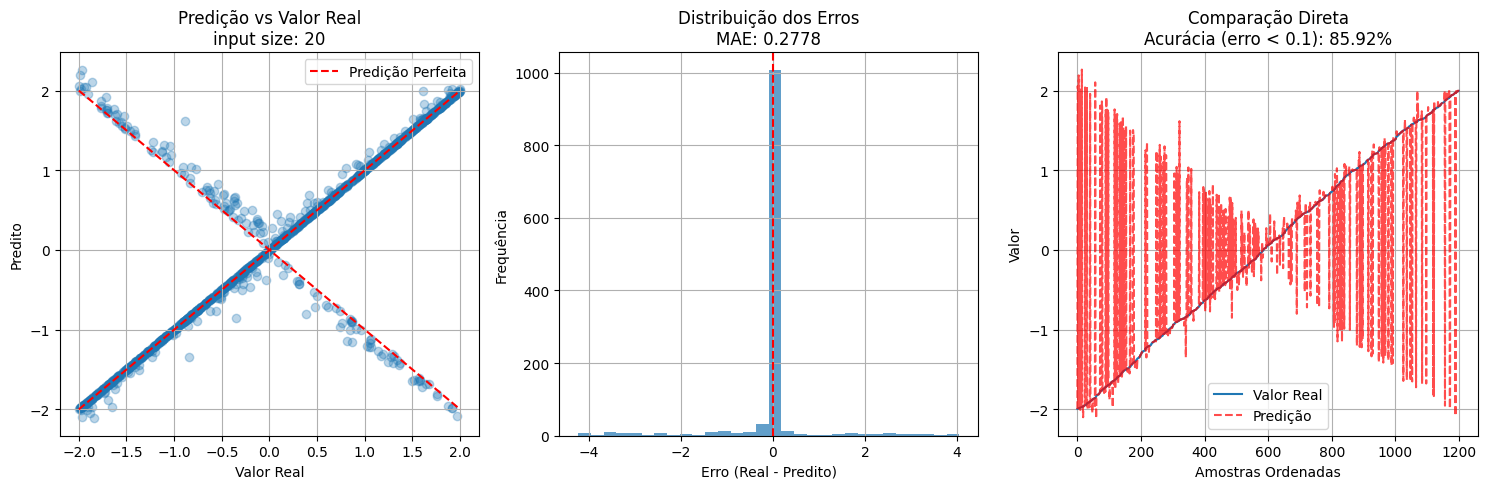


Erro Médio Absoluto (MAE): 0.2778
Acurácia (erro < 0.1): 85.92%


In [81]:
# Example usage of the function with the existing variables
evaluate_and_plot_prediction(y_test, y_pred,n)

In [21]:
joblib.dump(mlp, "mlp.pkl")





['mlp.pkl']

In [22]:
import joblib

In [23]:
mlp = joblib.load("mlp.pkl")

In [24]:
X_test[0]
np.min(np.abs(X_test[0]))

np.float64(2.2736630361443764)

In [25]:

import random
import numpy as np
arr = [1.18701613,1.5862267,  2.2171731,  3.14,       1.77087009, 1.91680348,
 2.50468206, 2.69809437, 2.40844774, 3.14,       1.11790848, 0.93121415,
 0.87070709 ,1.23796082 ,1.51068437 ,2.73547101 ,2.08829594 ,1.37747812,
 1.02584541 ,0.83217162]
idx = mlp.predict([arr])[0]
print(arr[idx])
print(np.min(np.abs(arr)))

2.40844774
0.83217162


In [26]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 100, 50),
                             activation='relu', **params[-1], # Se params[-1] contiver parâmetros válidos para MLPRegressor
                             verbose=True, max_iter=1000, random_state=42,
                             early_stopping=True, n_iter_no_change=20)
mlp_regressor.fit(X_train, y_train)

y_pred = mlp_regressor.predict(X_test)


Iteration 1, loss = 1.73619706
Validation score: 0.026002
Iteration 2, loss = 1.57701640
Validation score: 0.013859
Iteration 3, loss = 1.54048623
Validation score: 0.088824
Iteration 4, loss = 1.48836751
Validation score: 0.088528
Iteration 5, loss = 1.49603114
Validation score: 0.099798
Iteration 6, loss = 1.48881498
Validation score: 0.083266
Iteration 7, loss = 1.46324762
Validation score: 0.089942
Iteration 8, loss = 1.51418515
Validation score: 0.043823
Iteration 9, loss = 1.47627197
Validation score: 0.107864
Iteration 10, loss = 1.45164480
Validation score: 0.093203
Iteration 11, loss = 1.47048814
Validation score: 0.090634
Iteration 12, loss = 1.46366017
Validation score: 0.124781
Iteration 13, loss = 1.45200438
Validation score: 0.085204
Iteration 14, loss = 1.46691580
Validation score: 0.139138
Iteration 15, loss = 1.42964989
Validation score: 0.063447
Iteration 16, loss = 1.47528604
Validation score: 0.148663
Iteration 17, loss = 1.43131489
Validation score: 0.155100
Iterat

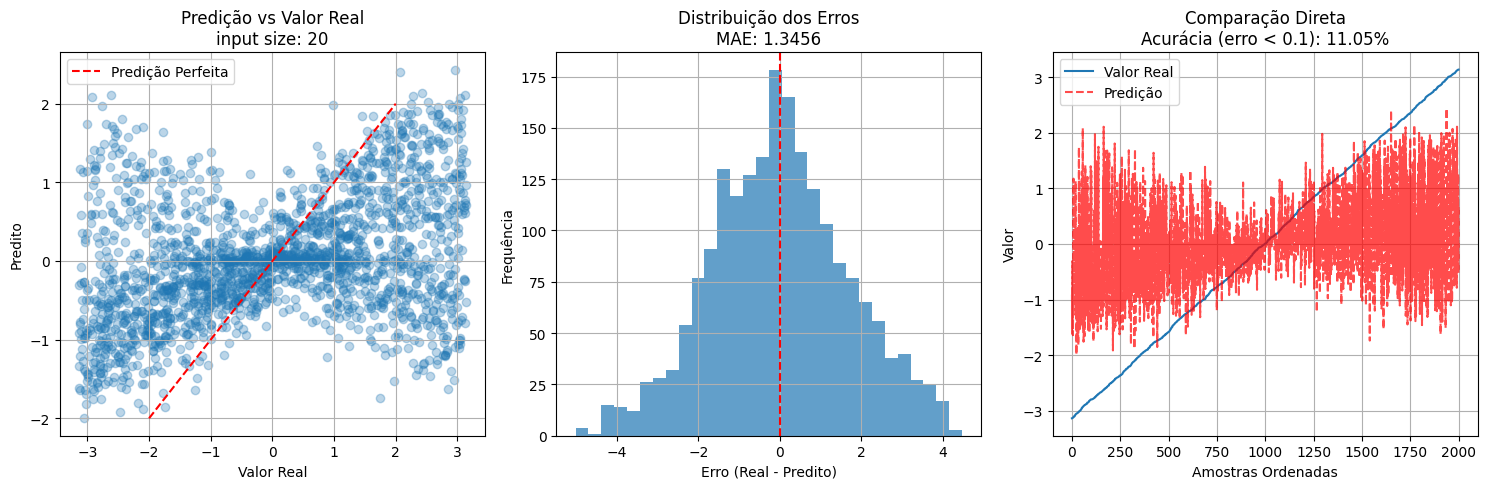


Erro Médio Absoluto (MAE): 1.3456
Acurácia (erro < 0.1): 11.05%


In [27]:
evaluate_and_plot_prediction(y_test, y_pred,n)

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
# ... (suas funções generate_data, generate_data2 e closest_to_zero)

# 1. Gerar os dados (agora com a regra de sinal e y uniforme)
n_features = 20 # Deve ser par!
num_samples_total = 6000 # Exemplo
y_uniform_range = (-2.0, 2.0)
x_max_other_magnitude = 5.0 # Deve ser maior que abs max de y_uniform_range

X, y = generate_data2(n_features, num_samples_total, y_uniform_range, x_max_other_magnitude)

# 2. Dividir em treino e teste (exemplo)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Escalonar os dados de ENTRADA (X)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# 4. Escalonar os dados de SAÍDA (y) - IMPORTANTE PARA REGRESSÃO COM MLP
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)) # reshape para 2D
# y_test_scaled não é estritamente necessário para predição, mas útil para avaliação se for escalar y_pred
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# 5. Treinar o MLPRegressor com dados escalados
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50, 50),
                             activation='relu',
                             solver='adam', # 'adam' é um bom default
                             learning_rate_init=0.001, # Ajuste conforme necessário
                             max_iter=2000, # Aumente as iterações
                             random_state=42,
                             early_stopping=True,
                             n_iter_no_change=50, # Aumente para dar mais chance de convergência
                             verbose=True)

mlp_regressor.fit(X_train_scaled, y_train_scaled.ravel()) # .ravel() para voltar para 1D

# 6. Fazer predições e inverter o escalonamento para avaliação
y_pred_scaled = mlp_regressor.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten() # Inverte e volta para 1D

# Agora você pode avaliar y_pred contra y_test e gerar os gráficos
# (certifique-se de que a função de plotagem usa os valores não escalados para o plot)


Iteration 1, loss = 0.50146246
Validation score: 0.035606
Iteration 2, loss = 0.45566189
Validation score: 0.076067
Iteration 3, loss = 0.43211613
Validation score: 0.097662
Iteration 4, loss = 0.41539278
Validation score: 0.107798
Iteration 5, loss = 0.40202551
Validation score: 0.114816
Iteration 6, loss = 0.39099810
Validation score: 0.123399
Iteration 7, loss = 0.37788331
Validation score: 0.130723
Iteration 8, loss = 0.36685380
Validation score: 0.125578
Iteration 9, loss = 0.35534523
Validation score: 0.128017
Iteration 10, loss = 0.34584702
Validation score: 0.118686
Iteration 11, loss = 0.33133455
Validation score: 0.127676
Iteration 12, loss = 0.32260149
Validation score: 0.113677
Iteration 13, loss = 0.31138542
Validation score: 0.123666
Iteration 14, loss = 0.30321151
Validation score: 0.091212
Iteration 15, loss = 0.29097834
Validation score: 0.091626
Iteration 16, loss = 0.27944684
Validation score: 0.108843
Iteration 17, loss = 0.26941610
Validation score: 0.101271
Iterat

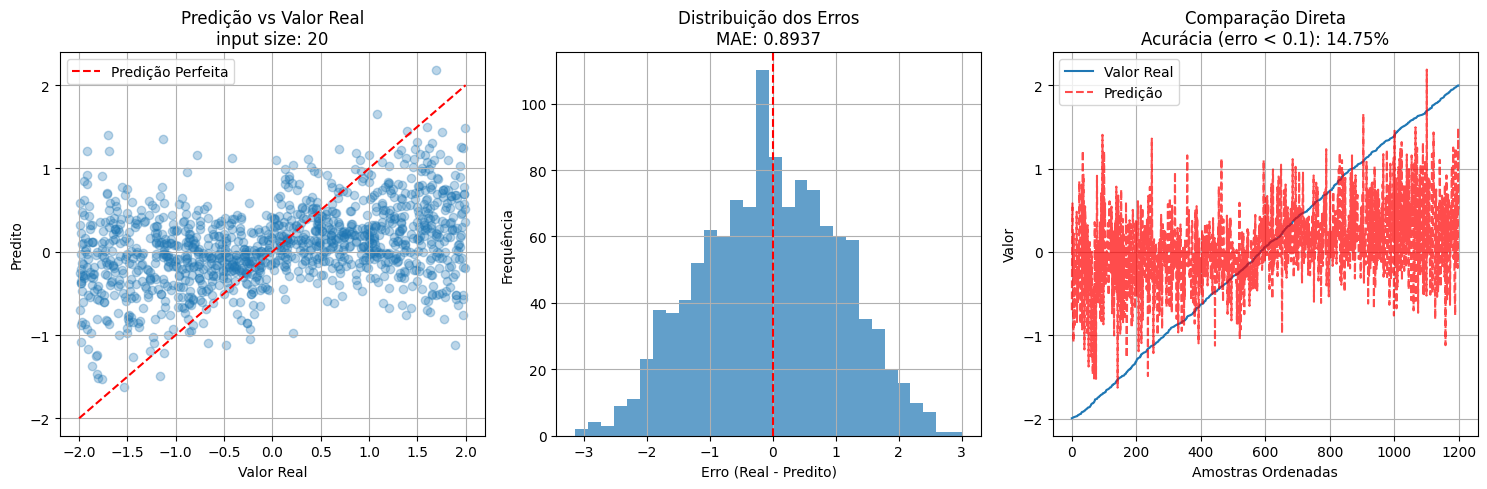


Erro Médio Absoluto (MAE): 0.8937
Acurácia (erro < 0.1): 14.75%


In [29]:
evaluate_and_plot_prediction(y_test, y_pred,n)

In [30]:

joblib.dump(mlp, "mlp.pkl")

mlp2 = joblib.load("model.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'model.pkl'

In [ ]:

def plot_history(history):
    # Plot training & validation loss
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot accuracy if available
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()

    plt.tight_layout()
    plt.show()

## tensorflow


In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Reshape,GlobalAveragePooling1D,MultiHeadAttention,Input, Lambda, Conv1D, Dense, Concatenate, Layer
from tensorflow.keras.optimizers import Adam

2025-07-14 01:53:28.445689: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 01:53:28.448394: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-14 01:53:28.455042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752468808.466890  150282 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752468808.470098  150282 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752468808.478919  150282 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
class MinFinderLossLayer(Layer):
    def call(self, inputs):
        input_values, scores = inputs
        abs_values = tf.abs(input_values)
        true_min_indices = tf.argmin(abs_values, axis=1)
        loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=true_min_indices,
                logits=scores
            )
        )
        self.add_loss(loss)
        return scores  # Pass through the scores


In [ ]:
def create_model(max_length=20):
    input_layer = Input(shape=(max_length,))
    abs_values = Lambda(lambda x: tf.abs(x))(input_layer)
    x = Concatenate()([input_layer, abs_values])
    x = Reshape((max_length*2, 1))(x)

    # Dilated convolutions for wider receptive field
    x = Conv1D(64, 3, dilation_rate=1, activation='relu', padding='same')(x)
    x = Conv1D(64, 3, dilation_rate=2, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)

    scores = Dense(max_length)(x)
    model = Model(input_layer, MinFinderLossLayer()([input_layer, scores]))
    model.compile(optimizer=Adam(0.001))
    return model
model = create_model(max_length=n)


E0000 00:00:1752468847.391345  150282 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752468847.395408  150282 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:

def create_model(max_length=20):
    input_layer = Input(shape=(max_length,))

    # Create absolute values and combine with original
    abs_values = Lambda(lambda x: tf.abs(x))(input_layer)
    merged = Concatenate(axis=-1)([input_layer, abs_values])  # Shape: (batch, max_length*2)

    # Reshape to 3D for Conv1D: (batch, steps=max_length*2, channels=1)
    x = Reshape((max_length*2, 1))(merged)

    # Feature extraction
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)

    # Multi-head attention (4 heads, 16-dim keys)
    att = MultiHeadAttention(num_heads=4, key_dim=16)(x, x)  # Self-attention
    x = Concatenate(axis=-1)([x, att])  # Combine conv and attention features

    # Global pooling and scoring
    x = GlobalAveragePooling1D()(x)
    scores = Dense(max_length, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=MinFinderLossLayer()([input_layer, scores]))
    model.compile(optimizer=Adam(0.001))
    return model
# Recreate and retrain your model
model = create_model(max_length=n)
history= model.fit(x=X_train, y=None, epochs=100, batch_size=128)

E0000 00:00:1752463694.669007   34421 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1752463694.671472   34421 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.0032
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9922
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9871
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9902
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9871
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9865
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9864
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9854
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9819
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9853
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9850
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9801
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9699
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9808
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9531
Epoc

In [ ]:
history=model.fit(x=X_train, y=None, epochs=200, batch_size=64)


Epoch 1/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0050
Epoch 2/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9898
Epoch 3/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9851
Epoch 4/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9820
Epoch 5/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9694
Epoch 6/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9597
Epoch 7/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9451
Epoch 8/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9217
Epoch 9/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8924
Epoch 10/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8503
Epoch 11/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8131
Epoch 12/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7655
Epoch 13/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7139
Epoch 14/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6776
Epoch 15/200
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6281
Epoc

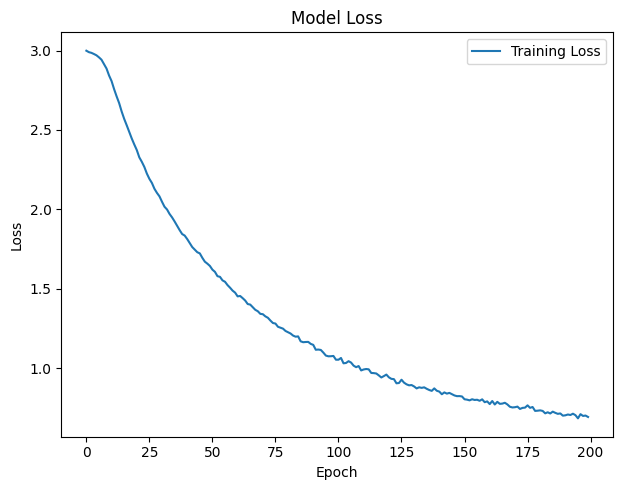

In [ ]:
plot_history(history)

In [ ]:
def predict_batch(model, input_arrays):
    """
    Predict on a batch of arrays for better efficiency
    """
    # Convert to numpy array
    input_batch = np.array(input_arrays)

    # Get raw scores for all samples at once
    scores = model.predict(input_batch, verbose=0)

    # Print shape of scores and predicted_indices for debugging
    print("Shape of scores:", scores.shape)

    # Get indices of the element with the highest score (which corresponds to the predicted index of the closest to zero value)
    predicted_indices = np.argmax(scores, axis=1)
    print("Predicted indices (first 10):", predicted_indices[:10])
    print("Max predicted index:", np.max(predicted_indices))


    # Select the corresponding values from the original input arrays
    y_pred = np.array([arr[idx] for arr, idx in zip(input_arrays, predicted_indices)])

    return y_pred

# Usage
y_pred = predict_batch(model, X_test)

Shape of scores: (1200, 20)
Predicted indices (first 10): [ 6  6 13  5 11  9 17 12  6 17]
Max predicted index: 19


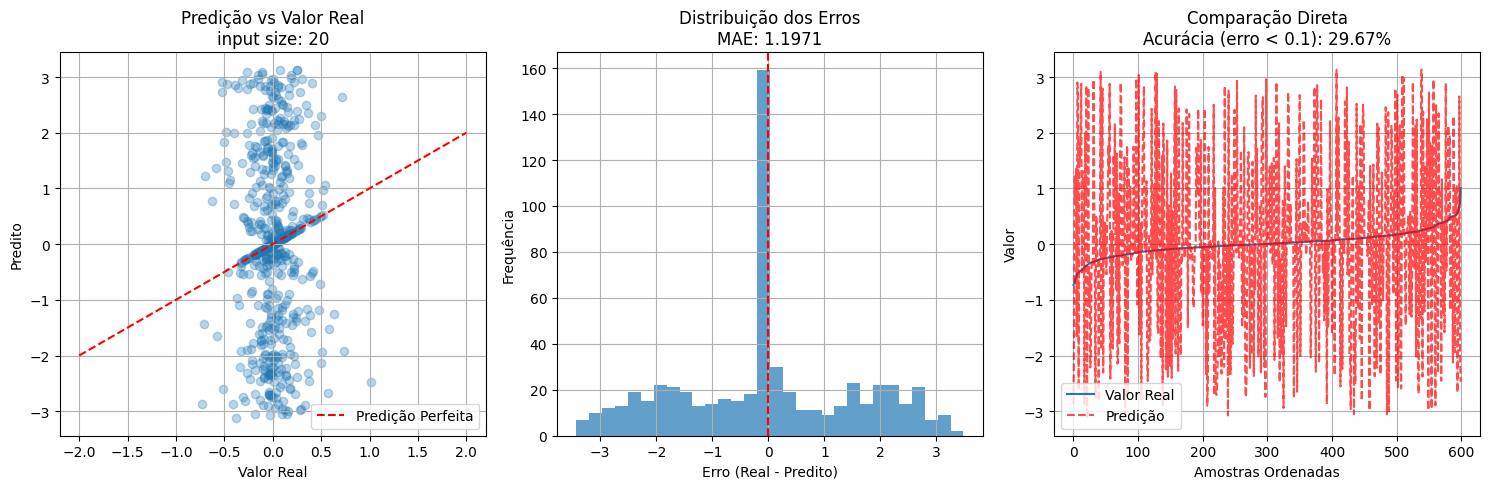


Erro Médio Absoluto (MAE): 1.1971
Acurácia (erro < 0.1): 29.67%


In [ ]:
evaluate_and_plot_prediction(y_test, y_pred,n)


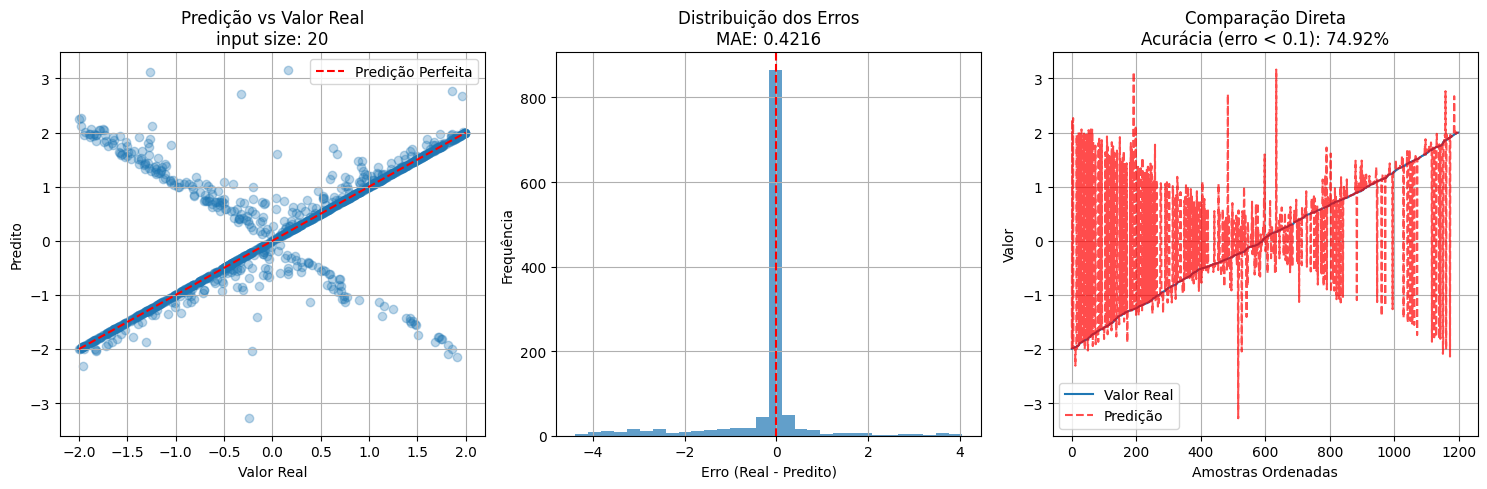


Erro Médio Absoluto (MAE): 0.4216
Acurácia (erro < 0.1): 74.92%


In [ ]:

evaluate_and_plot_prediction(y_test, y_pred,n)

